In [1]:
# Mofication History
# v0.1 Initial
# v0.2 run in my laptop
# v0.3 run 3 models
# v0.4 Basic data augmentation
# v0.5 BATCH_SIZE = 32
# v0.6 less augmentation RMSProp, update the accuracyy calculation formula

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler

import imgaug as ia
from imgaug import augmenters as iaa


%matplotlib inline
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

from os import listdir
from os.path import join, basename, isdir, isfile
import shutil

from PIL import Image
import time


In [3]:
# Parameter Claim
BATCH_SIZE = 128        # Batch Size
LR         = 0.01       # Initial Learning Rate
EPOCH      = 200        # Training Epoches
IMAGE_SIZE = 224        # Image dimension
MOMENTUM   = 0.9        # Momentum
device     = 'cuda'

In [4]:
def train_model(data_loader, model, criterion, optimizer, epoch, scheduler=None, is_train=True):
    # switch to train or test mode
    model.train(is_train)
    if is_train and scheduler!=None:
        scheduler.step()
        
    running_loss = 0.0
    running_corrects = 0
    data_len = 0
    
    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device) 
        labels = labels.to(device) 

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # backward + optimize only if in training phase
        if is_train:
            loss.backward()
            optimizer.step()
            
        # statistics
        running_loss += loss.item()
        running_corrects += preds.eq(labels).sum().item()    
        data_len += len(labels)
        
    # Record statistics
    epoch_acc = 100.*running_corrects / data_len
    epoch_loss = running_loss / data_len
    
    if is_train:
        print('{:3d} epoch, training '.format(epoch+1), end='')
    else:
        print('            testing ', end='')
    print('accuracy: {:.1f}%'.format(epoch_acc))
    print('                    loss    : {:.3f}'.format(epoch_loss))
    return epoch_acc, epoch_loss

In [5]:
def transformation(size=224, aug=False):
    if aug:
        return transforms.Compose([
            transforms.RandomResizedCrop(size),
            #transforms.RandomAffine(45),
            #transforms.RandomRotation(90),
            #transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.555, 0.451, 0.344), (0.228, 0.238, 0.238)),
        ])
    else:
        return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize((0.555, 0.451, 0.344), (0.228, 0.238, 0.238)),
        ])       
        

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


class DatasetFromFolder(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        self.transform = transform

    def __getitem__(self, index):
        filename = self.image_filenames[index]
        input = Image.open(filename)
        #label = basename(filename).split('_', 1)[0]
        if self.transform:
            input = self.transform(input)
        label = basename(filename).split('_')[0:2]
        if label[0].isdigit():
            label = label[0]
        else:
            label = label[1]
        #print("filename, label", filename, label)
        return input, int(label)

    def __len__(self):
        return len(self.image_filenames)
    
    
def get_data_set(datadir, subdir='Food-11/training', aug=False):
    train_dir = join(datadir, subdir)
    return DatasetFromFolder(train_dir, transform=transformation(IMAGE_SIZE, aug))


def adjust_learning_rate(optimizer, epoch):
    lr = LR * (0.5 ** (epoch // 20))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    if epoch%20 == 0:
        print('Learning rate is {:.5f}'.format(lr))

In [6]:
# Main function
if __name__ == '__main__':
    classes = ('Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 'Rice',
               'Seafood', 'Soup', 'Vegetable/Fruit')
    
    mode = ['SCRATCH', 'ALL', 'LAST']
    
    # Data loading
    datadir = '../data'
    if not isdir(datadir):
        datadir = '/tmp/dataset-nctu'
    
    trainset = get_data_set('/tmp/work', 'LAB3-2/sampled_train', True)
    validset = get_data_set(datadir, 'Food-11/validation')
    TRAIN_SIZE, VALID_SIZE = len(trainset), len(validset)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
      

    best_accu = [0, 0, 0]
    train_accu, train_loss = [[],[],[]], [[],[],[]]
    val_accu, val_loss = [[],[],[]], [[],[],[]]
    
    for idx in range(3): #0:model_scrach, 1:model_all, 2:model_last
        print('Transfer learning mode {} is begining...'.format(mode[idx]))
        criterion = nn.CrossEntropyLoss()
        scheduler = None   
        
        if idx==0: # Training from scrach
            model = models.resnet18()
            model.fc = nn.Linear(model.fc.in_features, len(classes))
            #optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
            optimizer = optim.RMSprop(model.parameters(), lr=LR, alpha=0.9)

            
        elif idx==1: # Transfer learning and update all weights
            model = models.resnet18(pretrained=True)
            model.fc = nn.Linear(model.fc.in_features, len(classes))
            #optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
            optimizer = optim.RMSprop(model.parameters(), lr=LR, alpha=0.9)
            
        else: # Transfer learning and update only last layer's weight
            model = models.resnet18(pretrained=True)
            for param in model.parameters():
                param.requires_grad = False # do not update gradient
            model.fc = nn.Linear(model.fc.in_features, len(classes))
            #optimizer = optim.SGD(model.fc.parameters(), LR, momentum=MOMENTUM)
            optimizer = optim.RMSprop(model.fc.parameters(), lr=LR, alpha=0.9)
       
        model = model.to(device)

        # Do Training
        for epoch in range(EPOCH):
            # Adjust learning rate
            adjust_learning_rate(optimizer, epoch)

            # train for one epoch
            accu_t, loss_t = train_model(trainloader, model, criterion, optimizer, epoch, scheduler)
            train_accu[idx].append(accu_t)
            train_loss[idx].append(loss_t)
            accu_v, loss_v = train_model(validloader, model, criterion, optimizer, epoch, scheduler, False)
            val_accu[idx].append(accu_v)
            val_loss[idx].append(loss_v)
            if accu_v > best_accu[idx]:
                best_accu[idx] = accu_v
                fname = './ckpt/model_best_v06_'+mode[idx]+'.pth.tar'
                torch.save(model.state_dict(), fname)

        #print('Transfer learning mode {} is DONE.'.format(mode[idx]))
        del criterion
        del scheduler 
        del model
        del optimizer
    
    print('\n\nTransfer learning is DONE.')


Transfer learning mode SCRATCH is begining...
Learning rate is 0.01000
  1 epoch, training accuracy: 8.8%
                    loss    : 0.044
            testing accuracy: 9.0%
                    loss    : 6.342
  2 epoch, training accuracy: 9.7%
                    loss    : 0.021
            testing accuracy: 9.1%
                    loss    : 0.026
  3 epoch, training accuracy: 12.8%
                    loss    : 0.020
            testing accuracy: 10.7%
                    loss    : 0.019
  4 epoch, training accuracy: 11.8%
                    loss    : 0.020
            testing accuracy: 12.6%
                    loss    : 0.028
  5 epoch, training accuracy: 17.6%
                    loss    : 0.019
            testing accuracy: 16.6%
                    loss    : 0.018
  6 epoch, training accuracy: 15.8%
                    loss    : 0.019
            testing accuracy: 19.0%
                    loss    : 0.018
  7 epoch, training accuracy: 19.5%
                    loss    : 0.0

 60 epoch, training accuracy: 48.7%
                    loss    : 0.012
            testing accuracy: 38.1%
                    loss    : 0.015
Learning rate is 0.00125
 61 epoch, training accuracy: 55.9%
                    loss    : 0.011
            testing accuracy: 39.5%
                    loss    : 0.014
 62 epoch, training accuracy: 55.0%
                    loss    : 0.011
            testing accuracy: 42.5%
                    loss    : 0.014
 63 epoch, training accuracy: 54.5%
                    loss    : 0.011
            testing accuracy: 39.6%
                    loss    : 0.015
 64 epoch, training accuracy: 54.5%
                    loss    : 0.011
            testing accuracy: 39.1%
                    loss    : 0.015
 65 epoch, training accuracy: 54.1%
                    loss    : 0.011
            testing accuracy: 41.1%
                    loss    : 0.015
 66 epoch, training accuracy: 58.4%
                    loss    : 0.010
            testing accuracy: 40.8%
   

            testing accuracy: 42.4%
                    loss    : 0.016
117 epoch, training accuracy: 70.6%
                    loss    : 0.007
            testing accuracy: 42.1%
                    loss    : 0.016
118 epoch, training accuracy: 70.2%
                    loss    : 0.007
            testing accuracy: 42.8%
                    loss    : 0.016
119 epoch, training accuracy: 70.2%
                    loss    : 0.007
            testing accuracy: 42.0%
                    loss    : 0.016
120 epoch, training accuracy: 70.5%
                    loss    : 0.007
            testing accuracy: 43.5%
                    loss    : 0.016
Learning rate is 0.00016
121 epoch, training accuracy: 70.1%
                    loss    : 0.007
            testing accuracy: 43.3%
                    loss    : 0.016
122 epoch, training accuracy: 71.4%
                    loss    : 0.007
            testing accuracy: 43.6%
                    loss    : 0.016
123 epoch, training accuracy: 72.4%
   

173 epoch, training accuracy: 75.7%
                    loss    : 0.006
            testing accuracy: 42.9%
                    loss    : 0.016
174 epoch, training accuracy: 74.5%
                    loss    : 0.006
            testing accuracy: 42.6%
                    loss    : 0.016
175 epoch, training accuracy: 73.2%
                    loss    : 0.007
            testing accuracy: 42.8%
                    loss    : 0.016
176 epoch, training accuracy: 73.4%
                    loss    : 0.007
            testing accuracy: 42.3%
                    loss    : 0.016
177 epoch, training accuracy: 76.5%
                    loss    : 0.006
            testing accuracy: 42.7%
                    loss    : 0.016
178 epoch, training accuracy: 74.0%
                    loss    : 0.006
            testing accuracy: 42.6%
                    loss    : 0.016
179 epoch, training accuracy: 74.6%
                    loss    : 0.006
            testing accuracy: 42.4%
                    loss    

            testing accuracy: 25.0%
                    loss    : 0.017
 32 epoch, training accuracy: 32.9%
                    loss    : 0.015
            testing accuracy: 21.9%
                    loss    : 0.019
 33 epoch, training accuracy: 34.1%
                    loss    : 0.015
            testing accuracy: 21.9%
                    loss    : 0.018
 34 epoch, training accuracy: 34.4%
                    loss    : 0.015
            testing accuracy: 31.1%
                    loss    : 0.016
 35 epoch, training accuracy: 35.7%
                    loss    : 0.015
            testing accuracy: 12.6%
                    loss    : 0.026
 36 epoch, training accuracy: 34.0%
                    loss    : 0.015
            testing accuracy: 29.2%
                    loss    : 0.016
 37 epoch, training accuracy: 37.6%
                    loss    : 0.014
            testing accuracy: 32.8%
                    loss    : 0.015
 38 epoch, training accuracy: 36.5%
                    loss    

 88 epoch, training accuracy: 61.8%
                    loss    : 0.009
            testing accuracy: 42.2%
                    loss    : 0.015
 89 epoch, training accuracy: 62.3%
                    loss    : 0.009
            testing accuracy: 43.3%
                    loss    : 0.015
 90 epoch, training accuracy: 62.9%
                    loss    : 0.009
            testing accuracy: 43.1%
                    loss    : 0.015
 91 epoch, training accuracy: 62.0%
                    loss    : 0.009
            testing accuracy: 43.8%
                    loss    : 0.015
 92 epoch, training accuracy: 63.5%
                    loss    : 0.009
            testing accuracy: 43.5%
                    loss    : 0.015
 93 epoch, training accuracy: 64.7%
                    loss    : 0.008
            testing accuracy: 42.4%
                    loss    : 0.015
 94 epoch, training accuracy: 63.8%
                    loss    : 0.009
            testing accuracy: 40.0%
                    loss    

            testing accuracy: 42.5%
                    loss    : 0.018
145 epoch, training accuracy: 77.9%
                    loss    : 0.006
            testing accuracy: 42.8%
                    loss    : 0.018
146 epoch, training accuracy: 75.5%
                    loss    : 0.006
            testing accuracy: 42.8%
                    loss    : 0.019
147 epoch, training accuracy: 77.5%
                    loss    : 0.006
            testing accuracy: 42.3%
                    loss    : 0.018
148 epoch, training accuracy: 79.5%
                    loss    : 0.005
            testing accuracy: 42.8%
                    loss    : 0.018
149 epoch, training accuracy: 78.6%
                    loss    : 0.006
            testing accuracy: 42.6%
                    loss    : 0.019
150 epoch, training accuracy: 76.4%
                    loss    : 0.006
            testing accuracy: 42.8%
                    loss    : 0.018
151 epoch, training accuracy: 77.9%
                    loss    

Learning rate is 0.01000
  1 epoch, training accuracy: 14.6%
                    loss    : 0.079
            testing accuracy: 12.4%
                    loss    : 0.073
  2 epoch, training accuracy: 40.6%
                    loss    : 0.026
            testing accuracy: 46.7%
                    loss    : 0.017
  3 epoch, training accuracy: 48.7%
                    loss    : 0.017
            testing accuracy: 28.4%
                    loss    : 0.020
  4 epoch, training accuracy: 47.5%
                    loss    : 0.016
            testing accuracy: 47.3%
                    loss    : 0.014
  5 epoch, training accuracy: 52.9%
                    loss    : 0.015
            testing accuracy: 34.7%
                    loss    : 0.022
  6 epoch, training accuracy: 56.5%
                    loss    : 0.014
            testing accuracy: 57.0%
                    loss    : 0.011
  7 epoch, training accuracy: 53.0%
                    loss    : 0.015
            testing accuracy: 43.4%
   

            testing accuracy: 72.4%
                    loss    : 0.008
 58 epoch, training accuracy: 84.7%
                    loss    : 0.004
            testing accuracy: 73.0%
                    loss    : 0.007
 59 epoch, training accuracy: 82.8%
                    loss    : 0.004
            testing accuracy: 72.2%
                    loss    : 0.008
 60 epoch, training accuracy: 86.8%
                    loss    : 0.003
            testing accuracy: 70.5%
                    loss    : 0.008
Learning rate is 0.00125
 61 epoch, training accuracy: 85.4%
                    loss    : 0.004
            testing accuracy: 73.7%
                    loss    : 0.007
 62 epoch, training accuracy: 85.1%
                    loss    : 0.004
            testing accuracy: 72.9%
                    loss    : 0.007
 63 epoch, training accuracy: 87.1%
                    loss    : 0.003
            testing accuracy: 72.8%
                    loss    : 0.007
 64 epoch, training accuracy: 85.3%
   

114 epoch, training accuracy: 87.5%
                    loss    : 0.003
            testing accuracy: 73.7%
                    loss    : 0.007
115 epoch, training accuracy: 89.7%
                    loss    : 0.003
            testing accuracy: 73.8%
                    loss    : 0.007
116 epoch, training accuracy: 85.9%
                    loss    : 0.003
            testing accuracy: 74.0%
                    loss    : 0.007
117 epoch, training accuracy: 87.1%
                    loss    : 0.003
            testing accuracy: 73.7%
                    loss    : 0.007
118 epoch, training accuracy: 87.0%
                    loss    : 0.003
            testing accuracy: 73.4%
                    loss    : 0.007
119 epoch, training accuracy: 89.1%
                    loss    : 0.003
            testing accuracy: 73.1%
                    loss    : 0.007
120 epoch, training accuracy: 88.7%
                    loss    : 0.003
            testing accuracy: 73.7%
                    loss    

            testing accuracy: 73.8%
                    loss    : 0.007
173 epoch, training accuracy: 89.3%
                    loss    : 0.003
            testing accuracy: 73.7%
                    loss    : 0.007
174 epoch, training accuracy: 89.1%
                    loss    : 0.003
            testing accuracy: 73.7%
                    loss    : 0.007
175 epoch, training accuracy: 89.2%
                    loss    : 0.003
            testing accuracy: 73.6%
                    loss    : 0.007
176 epoch, training accuracy: 88.0%
                    loss    : 0.003
            testing accuracy: 73.9%
                    loss    : 0.007
177 epoch, training accuracy: 89.7%
                    loss    : 0.003
            testing accuracy: 73.8%
                    loss    : 0.007
178 epoch, training accuracy: 88.4%
                    loss    : 0.003
            testing accuracy: 73.8%
                    loss    : 0.007
179 epoch, training accuracy: 87.2%
                    loss    

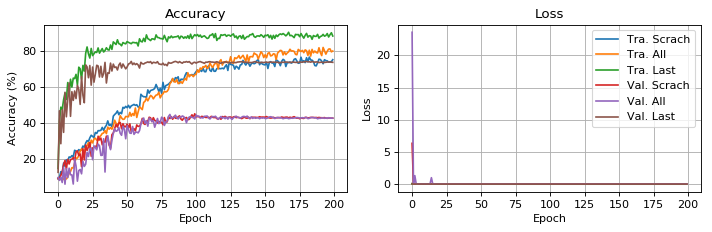

In [7]:
def draw_tri_accuracy(train_accu, train_loss, val_accu, val_loss):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,3), dpi=80)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Accuracy')
    ax1.grid(b=True)
    ax1.plot(train_accu[0], label='Tra. Scrach')
    ax1.plot(train_accu[1], label='Tra. All')
    ax1.plot(train_accu[2], label='Tra. Last')
    ax1.plot(val_accu[0], label='Val. Scrach')
    ax1.plot(val_accu[1], label='Val. All')
    ax1.plot(val_accu[2], label='Val. Last')

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss')
    ax2.grid(b=True)
    #ax2.set_ylim(0,10)
    ax2.plot(train_loss[0], label='Tra. Scrach')
    ax2.plot(train_loss[1], label='Tra. All')
    ax2.plot(train_loss[2], label='Tra. Last')
    ax2.plot(val_loss[0], label='Val. Scrach')
    ax2.plot(val_loss[1], label='Val. All')
    ax2.plot(val_loss[2], label='Val. Last')

    plt.legend()    
    plt.tight_layout()
    
draw_tri_accuracy(train_accu, train_loss, val_accu, val_loss)

In [8]:
# Evaluation
evaluateset = get_data_set(datadir, 'Food-11/evaluation')
evaluateloader = torch.utils.data.DataLoader(evaluateset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
criterion = nn.CrossEntropyLoss()
scheduler = None   
    
for idx in range(3): #0:model_scrach, 1:model_all, 2:model_last
    print('Evaluation of mode {}.'.format(mode[idx]))
    fname = './ckpt/model_best_v06_'+mode[idx]+'.pth.tar'
    model = models.resnet18()
    model.fc = nn.Linear(model.fc.in_features, len(classes))
    model.load_state_dict(torch.load(fname))
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
    
    train_model(evaluateloader, model, criterion, optimizer, 0, scheduler, False)
    
    del model
    del optimizer

Evaluation of mode SCRATCH.
            testing accuracy: 46.4%
                    loss    : 0.015
Evaluation of mode ALL.
            testing accuracy: 45.5%
                    loss    : 0.014
Evaluation of mode LAST.
            testing accuracy: 77.0%
                    loss    : 0.006
